In [2]:
from functions_text_model import *
import os
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import ParameterGrid

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
#tokenizer = BertTokenizer.from_pretrained('google/tinybert-msra-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [111]:
# Set hyperparameters
learning_rate = 0.0001
num_epochs = 5
batch_size = 64
weight_decay = 0.05 # L2 Regularization
dropout_prob = 0

In [112]:
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Create a new model
model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )


#for parameter in model.bert.parameters():    # Remove if training the entire model
#    parameter.requires_grad = False

model.to(device)

# Create a new optimizer with the current learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  #model.classifier.parameters()
# Create the optimizer  
criterion = nn.CrossEntropyLoss()

metrics = {'ACC': acc, 'F1-weighted': f1}
# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train Loss: 0.5320,  ACC: 0.7726, F1-weighted: 0.7689


100%|██████████| 3/3 [00:00<00:00, 18.52it/s]


eval Loss: 0.5848,  ACC: 0.7115, F1-weighted: 0.7060


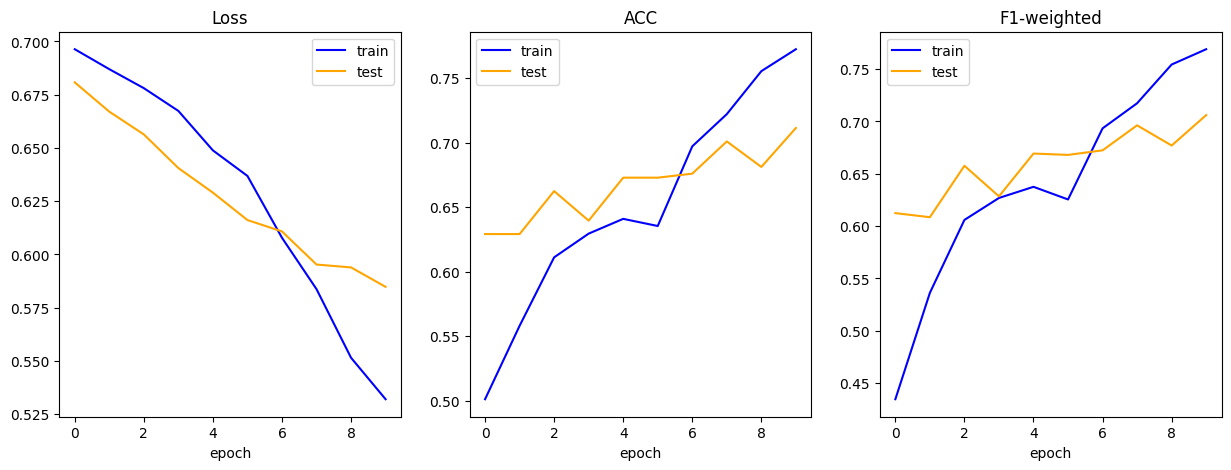

train loss [0.6963358918825785, 0.6869635383288065, 0.6780548824204339, 0.6673614184061686, 0.6488352020581564, 0.6368305815590752, 0.607799251874288, 0.583684245745341, 0.551461762852139, 0.5319996840424008] test loss [0.6807617743810018, 0.6670210957527161, 0.6563344796498617, 0.6405324737230936, 0.6289918621381124, 0.6161242922147115, 0.6107850273450216, 0.5952327648798624, 0.59388800462087, 0.5847596426804861]


In [113]:
# Train and evaluate the model for the current number of epochs
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)

    test_loss, test_metrics = evaluate(model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    #print('train metrics', train_metrics)
    #print('test metrics', eval_metrics)

print("train loss", train_loss_log, "test loss", test_loss_log)

In [101]:
################

torch.manual_seed(42)
    
# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5, 1e-6],
    'num_epochs': [10],
    'batch_size': [8, 16, 32, 64],
    'weight_decay' : [0.05, 0.1]
}


# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# For each combination of hyperparameters
for params in grid:
    # Create a new model
    model = BertForSequenceClassification.from_pretrained(
        "prajjwal1/bert-tiny",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
    )

    model.to(device)

    # Create a new optimizer with the current learning rate
    optimizer = AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    # Create the optimizer  
    criterion = nn.CrossEntropyLoss()

    metrics = {'ACC': acc, 'F1-weighted': f1}
    # Define the size of the training set and the test set
    train_size = int(0.8 * len(dataset))  # 80% of the data for training
    test_size = len(dataset) - train_size  # 20% of the data for testing

    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])


    # Train and evaluate the model for the current number of epochs
    for epoch in range(params['num_epochs']):
        print(f"Epoch {epoch + 1}")
        print('learning rate:', params['lr'], 'batch size:', params['batch_size'], 'num_epochs:', params['num_epochs'], 'weight decay:', params['weight_decay'])
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)
        eval_loss, eval_metrics = evaluate(model, criterion, metrics, test_dataloader, device)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'weight decay:': params['weight_decay'],
        'eval_loss': eval_loss,
        'eval_metrics': eval_metrics
    })

# Save the results to a JSON file
with open('results_tinybert_linear_added.json', 'w') as f:
    json.dump(results, f)

print(results)

train Loss: 0.4168,  ACC: 0.8587, F1-weighted: 0.8396


100%|██████████| 18/18 [00:00<00:00, 86.52it/s]


eval Loss: 1.5164,  ACC: 0.6181, F1-weighted: 0.5923
Epoch 6
learning rate: 0.001 batch size: 8 num_epochs: 10 weight decay: 0.05


 38%|███▊      | 26/69 [00:01<00:02, 15.53it/s]


KeyboardInterrupt: 

In [60]:
# Save the entire model
# torch.save(model.state_dict(), 'text-model-tinybert-fallback.pth')